## MIDI Data Combination V5
(1). 기준
- tick
- sec 0.1 초 단위

(2). precheck
- track 길이 / track_name 동일
- 시간 길이 거의 비슷

### 피아노 Midi 사이트
- https://www.freepianotutorials.net/2023/12/ludwig-goransson-can-you-hear-music.html#more
- http://www.piano-midi.de/bach.htm

### Ⅰ. 라이브러리

In [126]:
import os
import editdistance
import numpy as np
import pandas as pd

import mido
from mido import MidiFile, MidiTrack, MetaMessage, Message
from tqdm.notebook import tqdm

In [127]:
data_folder = "midi_data/"

In [128]:
sec_base = True
seq_base = True

sec_unit  = 0.1

In [129]:
###################################################
############  트랙 기본 정보
###################################################

def print_midi_info(mid):
    
    print("파일 이름: ", mid.filename)
    print("총 재생 시간: ", mid.length)
    
    if mid.tracks:
        total_tracks = len(mid.tracks)
        
        print("-"*70)
        print("트랙 이름: ", mid.tracks[0].name)
        print("총 트랙의 수: ", total_tracks)
        
        for i in range(total_tracks):
            if mid.tracks[i].name:
                track_name = mid.tracks[i].name
            else:
                track_name = None
            
            print(f"[{i+1}]. {mid.tracks[i].name}")
        
    else:
        print("트랙이 없습니다")

In [130]:
def load_midi_data(input_name, target_name):
    input_path  = os.path.join(data_folder, input_name)
    target_path = os.path.join(data_folder, target_name)
    
    input_mid  = mido.MidiFile(input_path)
    target_mid = mido.MidiFile(target_path)
    
    print("="*20, "[Input Midi Data]", "="*20)
    print_midi_info(input_mid)
    
    print()
    
    print("="*20, "[Target Midi Data]", "="*20)
    print_midi_info(target_mid)
    
    return input_mid, target_mid

### Ⅱ. 데이터 추출하기

In [131]:
def load_mid_Info_from_csv(input_mid, target_mid):
    
    input_name  = input_mid.filename
    target_name = target_mid.filename
    
    input_csv  = input_name.split(".")[0]+".csv"
    target_csv = target_name.split(".")[0]+".csv"
    
    input_info = pd.read_csv(input_csv)
    target_info = pd.read_csv(target_csv)
    
    #input_info = pd.read_csv(input_csv, index_col = 0)
    #target_info = pd.read_csv(target_csv, index_col = 0)
    
    return input_info, target_info


#### [1]. PreCheck
- track 길이
- track 이름
- 음의 길이

In [132]:
def pre_check(input_mid, target_mid):
    input_track_len  = len(input_mid.tracks)
    target_track_len = len(target_mid.tracks)
    
    # track 길이 비교
    if input_track_len != target_track_len:
        print(f"input track len({input_track_len}) != target track len({target_track_len})")
        return False
    
    # track_name 비교
    input_track_name  = [ msg.name for msg in input_mid if msg.type == 'track_name']
    target_track_name = [ msg.name for msg in target_mid if msg.type == 'track_name']
    
    if input_track_name != target_track_name:
        print(f"input track name({input_track_name}) != target track name({target_track_name})")
        return False
    
    # track 시간 비교 ( time_diff_interval 이상 비교 불가)
    input_mid_time  = input_mid.length
    target_mid_time = target_mid.length
    
    time_diff_interval = 20
    
    if abs(input_mid_time - target_mid_time) > time_diff_interval:
        print(f"input time({input_mid_time}) != target time({target_mid_time})")
        return False
    
    return True


#### [2]. MetaMessage

#### [3]. Message
- mean_velocity ( 평균 세기 ) : (( 셈여림 ))에 활용
- diff_velocity ( 세기 변화 ) 
    - 현재 노트의 평균 세기 - 이전 노트의 평균 세기
    - 음표의 세기, 빠르기의 변화에 활용
- dynamic ( 셈여림 )
|셈여림(dynamic)|정의|평균 velocity 범위|
|:--:|:--:|:--:|
|ppp(피아니시시모)|아주 여리게|0~35|
|pp(피아니시모)|매우 여리게|36~48|
|p(피아노)|여리게|49~61|
|mp(메조 피아노)|조금 여리게|62~74|
|mf(메조 포르테)|조금 세게|75~87|
|f(포르테)|세게|88~100|
|ff(포르티시모)|매우 세게|101~113|
|fff(포르티시시모)|아주 세게|114~127|

In [133]:
def create_df_info():
    #df_col = ['sec',
    #          'msg_type', 'channel', 'note', 'velocity', 'dynamic', 'accent', 'count',
    #          'main_vol','depth', 'pedal', 'pan', 'tempo']
    
    df_col = ['sec',
              'msg_type', 'channel', 'note', 'velocity', 'dynamic', 'accent', 'count',
              'main_vol','depth', 'pedal', 'pan']
    df = pd.DataFrame(columns = df_col)
    
    df_tempo_col = ['tempo', 'tick']
    df_tempo = pd.DataFrame(columns = df_tempo_col)

    df_info = { MetaMessage:{}, Message:df }
    
    return df_info, df_tempo

def info_to_list(cur_info):
    
    #cur_temp = [cur_info['sec'],
    #            cur_info['msg_type'], cur_info['channel'], cur_info['note'], 
    #            cur_info['velocity'], cur_info['dynamic'], cur_info['accent'], cur_info['count'],
    #            cur_info['main_vol'], cur_info['depth'], cur_info['pedal'], cur_info['pan'], cur_info['tempo']]
    
    cur_temp = [cur_info['sec'],
                cur_info['msg_type'], cur_info['channel'], cur_info['note'], 
                cur_info['velocity'], cur_info['dynamic'], cur_info['accent'], cur_info['count'],
                cur_info['main_vol'], cur_info['depth'], cur_info['pedal'], cur_info['pan']]
    return cur_temp
                

def initialize_cur_info():
    # cur_info = {'sec':0,
    #            'msg_type': [], 'channel':[], 'note':[],  'velocity':[], 'dynamic':"", 'accent':0, 'count':0,
    #            'main_vol':-1, 'depth':-1, 'pedal':-1, 'pan':-1, 'tempo':[] }
    
    cur_info = {'sec':0,
                'msg_type': [], 'channel':[], 'note':[],  'velocity':[], 'dynamic':"", 'accent':0, 'count':0,
                'main_vol':-1, 'depth':-1, 'pedal':-1, 'pan':-1}
    return cur_info

def check_not_list(msg_list):
    if type(msg_list) == list:
        return msg_list
    else:
        msg_list = [msg_list]
        return msg_list

In [134]:
def tempo_info_list(mid_info, tempo_info):
    
    #default tempo setting
    if 'set_tempo' not in mid_info[MetaMessage]:
        msg = mido.MetaMessage('set_tempo', tempo = 500000)
        
        mid_info[MetaMessage][msg.type] = [msg]
    
    tempo_list = mid_info[MetaMessage]['set_tempo']
    
    tempo_tick = 0
    
    for idx, msg in enumerate(tempo_list):
        tempo_tick += msg.time
            
        if idx==0:
            tempo_info.loc[idx,'tempo'] = msg.tempo
        else:
            tempo_info.loc[idx, 'tempo'] = msg.tempo
            tempo_info.loc[idx-1, 'tick'] = tempo_tick
            
    tempo_info.loc[tempo_info.shape[0] - 1, 'tick'] = -1
                    
    return tempo_info

def find_tempo(tick, tempo_info):
    tempo_idx = 0
    last_tempo_idx = tempo_info.shape[0]
    
    cur_tempo = -1
    
    for tempo_idx in range(last_tempo_idx):
        if tempo_info.loc[tempo_idx, 'tick'] > tick:
            cur_tempo = tempo_info.loc[tempo_idx, 'tempo']
            break
            
    if cur_tempo == -1:
        cur_tempo = tempo_info.loc[last_tempo_idx - 1, 'tempo']
        
    return cur_tempo

In [135]:
###################################################
############  셈여림 정보
###################################################
def distribute_dynamic(mean_velocity):
    dynamic = ''
    if 0 <= mean_velocity < 36:
        dynamic = 'ppp'
    elif 36 <= mean_velocity < 49:
        dynamic = 'pp'
    elif 49 <= mean_velocity < 62:
        dynamic = 'p'
    elif 62 <= mean_velocity < 75:
        dynamic = 'mp'
    elif 75 <= mean_velocity < 88:
        dynamic = 'mf'
    elif 88 <= mean_velocity < 101:
        dynamic = 'f'
    elif 101 <= mean_velocity < 114:
        dynamic = 'ff'
    elif 114 <= mean_velocity <= 127:
        dynamic = 'fff'
    
    return dynamic

###################################################
############  셈여림, 악센트 계산 함수
###################################################
def calculate_dynamic_accent(cur_info, msg_df):
    
    last_idx = msg_df.shape[0]
    
    if last_idx>0:
        prev_velo = msg_df.loc[last_idx-1, 'velocity']
        prev_avg_velo = sum(prev_velo) / len(prev_velo) if prev_velo else 0
    else:
        prev_avg_velo = 0
        
    if cur_info['count'] > 0 :
        mean_velocity = sum(cur_info['velocity']) / len(cur_info['velocity'])
        diff_velocity = mean_velocity - prev_avg_velo
    else:
        mean_velocity = 0
        diff_velocity = 0
        
    dynamic = distribute_dynamic(mean_velocity)
    accent = 1 if 76 <= mean_velocity <= 127 and mean_velocity > 1.2 * prev_avg_velo else 0
    
    return dynamic, accent
    

In [136]:
def control_type(msg):
    
    ctl_type = None
    
    if msg.control == 1:
        ctl_type = 'modulation'
        
    elif msg.control == 7:
        ctl_type = 'main_vol'
        
    elif msg.control == 10:
        ctl_type = 'pan'
        
    elif msg.control == 64:
        ctl_type = 'pedal'
        
    elif msg.control >= 91 and msg.control <= 93:
        ctl_type = 'depth'
        
    return ctl_type

In [137]:
def process_msg(msg, info):
    
    if msg.type == 'note_on' or msg.type == 'note_off':
        
        if msg.type == 'note_on' and msg.velocity == 0:
            msg_type = 'note_off'
        else:
            msg_type = msg.type
                    
        info['msg_type'].append(msg_type)
        info['channel'].append(msg.channel)
        info['note'].append(msg.note)
        info['velocity'].append(msg.velocity)
                    
        info['count']+=1
        
    elif msg.type == 'program_change':
        print("program_change")
        return False
        
    elif msg.type == 'control_change':
        
        ctl_type = control_type(msg)
        
        # 수집하지 않은 control_type
        if ctl_type == None:
            return False
        
        if info[ctl_type] == -1:
            info[ctl_type] = msg.value
        else:
            info[ctl_type] = check_not_list(info[ctl_type])
            info[ctl_type].append(msg.value)
    
    return True

In [138]:
def remain_check(info):
    
    if info['count'] > 0:
        return True
    
    if info['main_vol'] != -1:
        return True
    
    if info['depth'] != -1:
        return True
    
    if info['pedal'] != -1:
        return True
    
    if info['pan'] != -1:
        return True
    
    return False

In [139]:
def extract_mid_data(mid):
    
    mid_info, tempo_info = create_df_info()
    tick_base = True
    
    for idx, track in enumerate(mid.tracks):
        
        cur_tick = 0
        cur_sec  = 0
        cur_info = initialize_cur_info()
        
        
        for i, msg in tqdm(enumerate(track)):
            
            # MetaMessage
            if isinstance(msg, MetaMessage):
                                
                if msg.type not in mid_info[MetaMessage]:
                    mid_info[MetaMessage][msg.type] = []
                    
                mid_info[MetaMessage][msg.type].append(msg)
            
            elif isinstance(msg, Message):
                
                cur_tick = cur_tick + msg.time
                
                msg_tempo = find_tempo(cur_tick, tempo_info)
                msg_sec = mido.tick2second( cur_tick, mid.ticks_per_beat, msg_tempo )
                msg_sec = np.trunc(msg_sec*10) / 10 # 소수 첫째 자리까지 버림
                
                if msg_sec > cur_sec:                        
                    
                    dynamic, accent = calculate_dynamic_accent(cur_info, mid_info[Message])
                    
                    cur_info['dynamic'] = dynamic
                    cur_info['accent'] = accent
                    
                    cur_info['sec'] = cur_sec
                    
                    cur_temp = info_to_list(cur_info)
                    
                    info_cur = int(msg_sec * 10)
                    info_last = mid_info[Message].shape[0]
                                        
                    mid_info[Message].loc[info_last] = cur_temp
                    
                    if sec_base == True:
                        
                        # empty music
                        temp_info = initialize_cur_info()
                        temp_temp = info_to_list(temp_info)
                        
                        for sec in range(info_last + 1, info_cur):
                            temp_temp[0] = float(sec / 10)
                            
                            mid_info[Message].loc[sec] = temp_temp
                                                    
                    cur_info = initialize_cur_info()

                isProcess = process_msg(msg, cur_info)
                if isProcess == False:
                    continue
                
                # tempo
                # msg_tempo = find_tempo(cur_tick, tempo_info)
                # cur_info['tempo'].append(msg_tempo)
                
                cur_sec = msg_sec
            
        if idx == 1 and remain_check(cur_info) == True:

            # 잔여 cur_info 추가
            dynamic, accent = calculate_dynamic_accent(cur_info, mid_info[Message])

            cur_info['dynamic'] = dynamic
            cur_info['accent'] = accent

            cur_info['sec'] = cur_sec

            cur_temp = info_to_list(cur_info)

            info_cur = int(msg_sec * 10)
            info_last = mid_info[Message].shape[0]
            
            if sec_base == True:
                
                # empty music
                temp_info = initialize_cur_info()
                temp_temp = info_to_list(temp_info)
                        
                for sec in range(info_last + 1, info_cur):
                    temp_temp[0] = float(sec / 10)
                            
                    mid_info[Message].loc[sec] = temp_temp
                                                    
            cur_info = initialize_cur_info()
            
        # tempo setting
        if idx == 0:
            tempo_info_list(mid_info, tempo_info)
            
            
    mid_info[Message].replace(-1, 0, inplace = True)
    
    csv_name = mid.filename.split(".")[0]+".csv"
    mid_info[Message].to_csv(csv_name, index = False)
    
    return mid_info


In [140]:
def extrack_mid_info(input_mid, target_mid):
    
    input_info  = extract_mid_data(input_mid)
    target_info = extract_mid_data(target_mid)
    
    print("="*20, "  [Input_Info[Message]]  ", "="*20)
    display(input_info[Message])
    
    print()
    
    print("="*20, "  [target_Info[Message]]  ", "="*20)
    display(target_info[Message])
    
    return input_info, target_info

### Ⅲ. 실행

#### [1]. 실행 코드

In [141]:
# input_name = "river_flows_in_you_test_v2.mid"
# target_name = "river_flows_in_you_origin.mid"

input_name  = "butterfly/butterfly_input_data.mid"
target_name = "butterfly/butterfly_target_data.mid"

input_mid, target_mid = load_midi_data(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/butterfly/butterfly_input_data.mid
총 재생 시간:  27.00000000000003
----------------------------------------------------------------------
트랙 이름:  butterfly
총 트랙의 수:  2
[1]. butterfly
[2]. PIANO

==================== [Target Midi Data] ====================
파일 이름:  midi_data/butterfly/butterfly_target_data.mid
총 재생 시간:  27.0
----------------------------------------------------------------------
트랙 이름:  butterfly
총 트랙의 수:  2
[1]. butterfly
[2]. PIANO


In [142]:
if pre_check(input_mid, target_mid):
    print("===== pre_check success =====")
    input_info, target_info = extrack_mid_info(input_mid, target_mid)
else:
    print("===== pre_check failed =====")

===== pre_check success =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
265,26.5,[],[],[],[],,0,0,0,0,0,0
266,26.6,[],[],[],[],,0,0,0,0,0,0
267,26.7,[],[],[],[],,0,0,0,0,0,0
268,26.8,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
265,26.5,[],[],[],[],,0,0,0,0,0,0
266,26.6,[],[],[],[],,0,0,0,0,0,0
267,26.7,[],[],[],[],,0,0,0,0,0,0
268,26.8,[],[],[],[],,0,0,0,0,0,0


In [143]:
# if pre_check(input_mid, target_mid):
#     print("===== pre_check success =====")
#     input_info, target_info = load_mid_Info_from_csv(input_mid, target_mid)
# else:
#     print("===== pre_check failed =====")

#### [2]. 임시방편

In [144]:
# input_msg_info  = pd.read_csv(data_folder+"/butterfly_input_data.csv",  keep_default_na=False)
# target_msg_info = pd.read_csv(data_folder+"/butterfly_target_data.csv", keep_default_na=False)

In [145]:
display(input_msg_info)
print("="*25)
display(target_msg_info)

,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],1,0,0,100,0,0,64
1,0.1,[],[],[],[],0,0,0,0,0,0,0
2,0.2,[],[],[],[],0,0,0,0,0,0,0
3,0.3,[],[],[],[],0,0,0,0,0,0,0
4,0.4,[],[],[],[],0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
265,26.5,[],[],[],[],0,0,0,0,0,0,0
266,26.6,[],[],[],[],0,0,0,0,0,0,0
267,26.7,[],[],[],[],0,0,0,0,0,0,0
268,26.8,[],[],[],[],0,0,0,0,0,0,0


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],1,0,0,100,0,0,64
1,0.1,[],[],[],[],0,0,0,0,0,0,0
2,0.2,[],[],[],[],0,0,0,0,0,0,0
3,0.3,[],[],[],[],0,0,0,0,0,0,0
4,0.4,[],[],[],[],0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
265,26.5,[],[],[],[],0,0,0,0,0,0,0
266,26.6,[],[],[],[],0,0,0,0,0,0,0
267,26.7,[],[],[],[],0,0,0,0,0,0,0
268,26.8,[],[],[],[],0,0,0,0,0,0,0


### Ⅳ. 비교 알고리즘

#### [0]. 사전 작업
- 정답 데이터의 tick 행 길이에 맞추는 작업
- 입력 데이터의 tick 행 길이가 적을 경우, 0 으로 처리

In [146]:
def align_and_save_dataframes(input_mid, target_mid):
    
    input_filename  = input_mid.filename
    target_filename = target_mid.filename
    
    input_file  = input_filename.split(".")[0] +".csv"
    target_file = target_filename.split(".")[0]+".csv"
    
    df_input  = pd.read_csv(input_file)
    df_target = pd.read_csv(target_file)
    
    print("Input shape: ", df_input.shape)
    print("Target shape:", df_target.shape)

    # target_file의 행 길이로 맞추기
    min_length = min(len(df_input), len(df_target))
    df_input_aligned = df_input.head(min_length)

    # target_file보다 행이 작으면 나머지 행은 0으로 채우기
    if len(df_input) < len(df_target):
        df_input_aligned = pd.concat([df_input_aligned, 
                                      pd.DataFrame(0, index=range(len(df_target) - len(df_input)), columns=df_input.columns)])

    # 모든 컬럼에 대해 0으로 채우기
    for col in df_input.columns:
        if col not in df_target.columns:
            df_input_aligned[col] = 0

    # msg_type, Notes, Velocities 컬럼에 대해 빈 리스트 []를 NaN으로 처리
    for col in ['msg_type', 'channel', 'note', 'velocity']:
        df_input_aligned[col] = df_input_aligned[col].apply(lambda x: [] if x == 0 else x)

    df_input_aligned.to_csv(input_file, index=False)
    df_target.to_csv(target_file, index=False)
    
    return df_input_aligned, df_target

In [147]:
input_msg_info, target_msg_info = align_and_save_dataframes(input_mid, target_mid)

Input shape:  (270, 12)
Target shape: (270, 12)


#### [1]. 노트 정확도 ( 음정 정확도 : pitch accuracy )
- 입력 데이터와 정답 데이터의 Notes 를 비교하여, 현재 노트가 거의 일치하면 1.5점을 부여, 약간의 차이는 1점 부여, 조금 더 많이 차이나면 0.5점 부여

In [148]:
def calculate_note_accuracy(df_input, df_target):

    total_accuracy = 0

    for index in range(len(df_input)):
        notes_input = eval(df_input.at[index, 'note'])
        notes_target = eval(df_target.at[index, 'note'])
        
        # 0으로 된 값 리스트로 처리
        if isinstance(notes_input, int):
            notes_input = [notes_input]
        if isinstance(notes_target, int):
            notes_target = [notes_target]
        
        # 현재 행의 정확도 초기화
        row_accuracy = 0

        # 한 행에 있는 리스트들 간의 비교
        for note_input in set(notes_input):
            for note_target in set(notes_target):
                if note_input == 0 or note_input == None: # 0 또는 Null이면 계산에 포함하지 않음
                    pass
                
                # 음정 차이 계산 - 노트 번호 차이에 따라 가중치 부여
                pitch_difference = abs(note_input - note_target)
                
                # 약간의 차이에도 점수 부여
                if pitch_difference == 0:
                    pass
                elif pitch_difference <= 1:
                    row_accuracy += 1.5
                elif pitch_difference <= 2:
                    row_accuracy += 1  # 1차적인 음정 차이보다 크지만 약간의 차이라면 1점 부여
                elif pitch_difference <= 3:
                    row_accuracy += 0.3  # 1차적인 음정 차이보다 크지만 약간의 차이라면 0.5점 부여

        total_accuracy += row_accuracy
                    # print('-'*10)
                    # print(f'!!!{row_accuracy}점 추가!!!')
                    
                # 비교하는 대상들 출력
                # print(f'비교 데이터 - 입력 데이터: {notes_input[j]} / 정답 데이터: {notes_target[i]}')

        # 한 행의 정확도를 전체 정확도에 추가
        total_accuracy += row_accuracy
        # print(f'현재 점수: {total_accuracy}점')
        # print()

    # 전체 정확도 계산
    max_possible_accuracy = len(df_target)
    accuracy_percentage = min(1000, (total_accuracy / max_possible_accuracy) * 100)

    return f'{accuracy_percentage:.2f}%'


In [149]:
accuracy = calculate_note_accuracy(input_msg_info, target_msg_info)
print(f'음정 정확도: {accuracy}')

음정 정확도: 82.00%


#### [2]. 셈여림

In [166]:
# 이전 코드

def calculate_similarity_dynamic(input_df, target_df):

    input_counts = input_df['dynamic'].value_counts().to_dict()
    target_counts = target_df['dynamic'].value_counts().to_dict()
    # print(input_counts)
    # print(target_counts)
    
    # 공통된 'Dynamic' 값들의 유사도 계산
    common_keys = set(input_counts) & set(target_counts)

    # 총 가능한 차이의 합 및 실제 차이의 합 계산
    total_possible_difference = sum(max(input_counts.get(key, 0), target_counts.get(key, 0)) for key in common_keys)
    actual_difference = sum(abs(input_counts.get(key, 0) - target_counts.get(key, 0)) for key in common_keys)

    # ((총 가능한 차이의 합 - 실제 차이의 합) / 총 가능한 차이의 합) * 100
    similarity_percentage = ((total_possible_difference - actual_difference) / total_possible_difference) * 100
    return f'{similarity_percentage:.2f}%'

In [167]:
dynamic_similarity = calculate_similarity_dynamic(input_msg_info, target_msg_info)
print(f'셈여림 유사도: {dynamic_similarity}')

셈여림 유사도: 32.62%


In [257]:
# Cosine Similarity Test
from sklearn.metrics.pairwise import cosine_similarity

data1 = np.array([1, 2, 3, 4]).reshape(1, -1)
data2 = np.array([5, 6, 7, 8]).reshape(1, -1)
data3 = np.array([4, 2, 1, 3]).reshape(1, -1)
data4 = np.array([7, 8, 5, 6]).reshape(1, -1)

def calculate_cosine_similarity(data1, data2):
    similarity = cosine_similarity(data1, data2)[0][0]
    return similarity

similarity_12 = calculate_cosine_similarity(data1, data2)
print("데이터 1과 2의 코사인 유사도:", similarity_12)

similarity_34 = calculate_cosine_similarity(data3, data4)
print("데이터 3과 4의 코사인 유사도:", similarity_34)

데이터 1과 2의 코사인 유사도: 0.9688639316269663
데이터 3과 4의 코사인 유사도: 0.9273411917000962


In [201]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_dataframe(df):
    # 'dynamic' 열의 값을 규칙에 따라 대체
    replace_dict = {np.nan: 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}
    df = df.replace(replace_dict)
    return df

def calculate_similarity_cosine(input_df, target_df):
    # 데이터프레임 전처리
    input_df = input_df['dynamic']
    target_df = target_df['dynamic']

    input_df = preprocess_dataframe(input_df)
    target_df = preprocess_dataframe(target_df)
    
    input_array = input_df.values.reshape(1, -1)
    target_array = target_df.values.reshape(1, -1)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(input_array, target_array)
    average_similarity = np.mean(similarities)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(input_array, annot=True, cmap='coolwarm', cbar=False)
    plt.title('Input Data')

    plt.subplot(1, 2, 2)
    sns.heatmap(target_array, annot=True, cmap='coolwarm', cbar=False)
    plt.title('Target Data')

    plt.show()
    
    for input_data, target_data in zip(input_df, target_df):
        print(f'[input: {input_data}] [target: {target_data}]')

    return f'{average_similarity * 100:.2f}%'

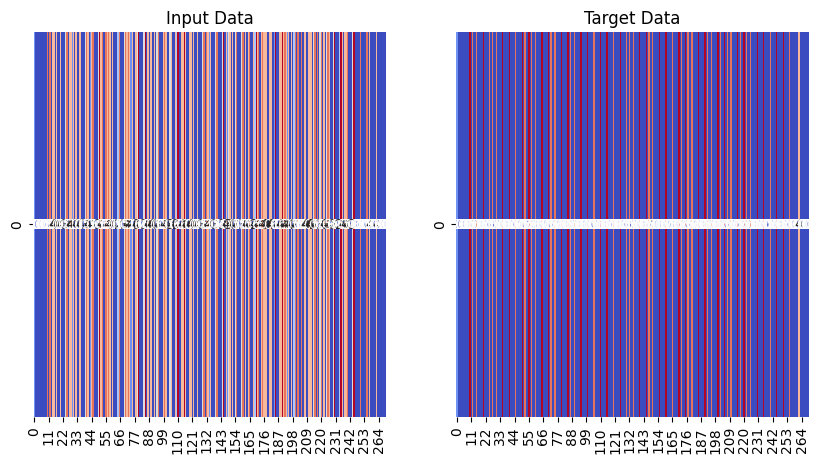

[input: 1] [target: 1]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 5] [target: 6]
[input: 0] [target: 0]
[input: 5] [target: 5]
[input: 0] [target: 0]
[input: 4] [target: 0]
[input: 4] [target: 5]
[input: 0] [target: 0]
[input: 4] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 4] [target: 6]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 3] [target: 0]
[input: 5] [target: 5]
[input: 0] [target: 0]
[input: 4] [target: 5]
[input: 4] [target: 0]
[input: 1] [target: 0]
[input: 4] [target: 5]
[input: 0] [target: 0]
[input: 4] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 4] [target: 6]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 0] [target: 0]
[input: 3] [target: 0]
[input: 5] [target: 6]
[input: 4] [target: 0]
[input: 0] [target: 0]
[input: 1] 

In [202]:
dynamic_similarity = calculate_similarity_cosine(input_msg_info, target_msg_info)
print(f'셈여림 유사도: {dynamic_similarity}')

In [203]:
# 최종 코드

def calculate_similarity_dynamic(input_df, target_df):
    # 데이터프레임 전처리
    input_df = input_df['dynamic']
    target_df = target_df['dynamic']

    input_df = preprocess_dataframe(input_df)
    target_df = preprocess_dataframe(target_df)
    
    input_array = input_df.values.reshape(1, -1)
    target_array = target_df.values.reshape(1, -1)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(input_array, target_array)
    average_similarity = np.mean(similarities)

    return f'{average_similarity * 100:.2f}%'

#### [3]. 셈여림의 변화 일관성

In [219]:
def calculate_dynamic_change_consistency(df_input, df_target):
    dynamic_series_input = df_input['dynamic']
    dynamic_series_target = df_target['dynamic']

    dynamic_states_input = zip(dynamic_series_input, dynamic_series_input.shift(-1))
    dynamic_states_target = zip(dynamic_series_target, dynamic_series_target.shift(-1))

    # 상태 바뀌는 부분 빈도수 계산
    dynamic_counter_input = pd.Series(dynamic_states_input).value_counts().to_dict()
    dynamic_counter_target = pd.Series(dynamic_states_target).value_counts().to_dict()
    # 입력 파일과 정답 파일에서 공통으로 나타나는 공통 패턴 찾기
    common_patterns = {state: min(dynamic_counter_input.get(state, 0), dynamic_counter_target.get(state, 0)) for state in set(dynamic_counter_input) | set(dynamic_counter_target)}
    # 일관성 백분율 계산
    total_common_patterns = sum(common_patterns.values())
    total_target_patterns = sum(dynamic_counter_target.values())
    dynamic_change_consistency_percentage = min(100, (total_common_patterns / total_target_patterns) * 100)


    return f'{dynamic_change_consistency_percentage:.2f}%'

In [220]:
dynamic_change_score = calculate_dynamic_change_consistency(input_msg_info, target_msg_info)
print(f'셈여림 변화 일관성: {dynamic_change_score}')

셈여림 변화 일관성: 38.52%


#### [4]. 곡의 빠르기 유사도
- 0.1초마다 곡의 bpm 값 필요

#### [5]. 곡의 빠르기의 변화 일관성
- 0.1초마다 곡의 bpm 값 필요

#### [6]. 붙임줄, 스타카토, 테누토, 늘임표
- 참고: https://cool-mantis-03f.notion.site/061187508f8841d7a5a6cda02792bea8?pvs=4

#### [7]. 악센트 정확도

In [221]:
def calculate_accent_accuracy(input_data, target_data):

    accent_score = 0

    input_time_range = []
    target_time_range = []

    start = 0
    end = 0
    isAccent = False

    for i in range(len(input_data)):
        # accent on
        if input_data['accent'][i] == 1 and isAccent == False:
            start = input_data['sec'][i]
            isAccent = True

        if input_data['accent'][i] == 0 and isAccent == True:
            end = input_data['sec'][i]
            isAccent = False
            input_time_range.append([start])
            start = 0
            end = 0

    start = 0
    end = 0
    isAccent = False

    for i in range(len(target_data)):
        # accent on
        if target_data['accent'][i] == 1 and isAccent == False:
            start = target_data['sec'][i]
            isAccent = True

        if target_data['accent'][i] == 0 and isAccent == True:
            end = target_data['sec'][i]
            isAccent = False
            target_time_range.append([start])
            start = 0
            end = 0

    for i in input_time_range:
        if i in target_time_range:
            accent_score += 1

    accent_score = int(accent_score / len(target_time_range) * 100)
    return f'{accent_score:.2f}%'

accent_accuracy = calculate_accent_accuracy(input_msg_info, target_msg_info)
print(f'악센트 정확도: {accent_accuracy}')

악센트 정확도: 57.00%


#### [8]. 옥타브

In [222]:
# 최종 코드

def calculate_euclidean_distance(notes1, notes2):
    if len(notes1) == 0 and len(notes2) == 0:
        return 0
    
    max_length = max(len(notes1), len(notes2))
    notes1 += [0] * (max_length - len(notes1))
    notes2 += [0] * (max_length - len(notes2))

    # 두 리스트 간의 유클리드 거리 계산
    distance = np.linalg.norm(np.array(notes1) - np.array(notes2))

    return distance

def calculate_octave_similarity(df_input, df_target):
    total_matched_octaves = 0
    total_notes = 0

    for index in range(len(df_input)):
        notes_input = eval(df_input.at[index, 'note'])
        notes_target = eval(df_target.at[index, 'note'])

        # 0으로 된 값 리스트로 처리
        if not isinstance(notes_input, list):
            notes_input = [notes_input]
        if not isinstance(notes_target, list):
            notes_target = [notes_target]

        # 벡터화 & 정규화
        input_octaves = list(set((note // 12) for note in notes_input))
        input_octaves = [octave / np.linalg.norm(input_octaves) for octave in input_octaves]
        target_octaves = list(set((note // 12) for note in notes_target))
        target_octaves = [octave / np.linalg.norm(target_octaves) for octave in target_octaves]

        # 현재 행의 일치하는 옥타브 수 초기화
        matched_octaves = 0

        # 한 행에 있는 리스트들 간의 비교
        # 수정된 부분: 유클리드 거리를 사용하여 옥타브 유사도 계산
        distance = calculate_euclidean_distance(input_octaves, target_octaves)
        similarity = 1 / (1 + distance)

        # 유사도가 일정 값 이상인 경우에 가중 점수 추가
        if similarity >= 0.8:
            matched_octaves += 1.2
        elif similarity >= 0.7:
            matched_octaves += 0.8
        elif similarity >= 0.6:
            matched_octaves += 0.6
        elif similarity >= .5:
            matched_octaves += 0.3

        total_matched_octaves += matched_octaves
        total_notes += len(set(input_octaves) | set(target_octaves))

    max_possible_matched_octaves = total_notes  # 모든 노트의 옥타브가 유사한 경우
    octave_similarity = min(100, (total_matched_octaves / max_possible_matched_octaves) * 100)

    return f'{octave_similarity:.2f}%'

In [223]:
octave_similarity = calculate_octave_similarity(input_msg_info, target_msg_info)
print(f"옥타브 유사도: {octave_similarity}")

옥타브 유사도: 76.43%


#### [9]. 꾸밈음, 반복기호

#### [10]. 리듬

#### [11]. 페달링

In [224]:
def calculate_pedal_consistency(df_input, df_target):
    pedal_series_input = df_input['pedal']
    pedal_series_target = df_target['pedal']
    
    pedal_states_input = zip(pedal_series_input, pedal_series_input.shift(-1))
    pedal_states_target = zip(pedal_series_target, pedal_series_target.shift(-1))
        
    pedal_counter_input = pd.Series(pedal_states_input).value_counts().to_dict()
    pedal_counter_target = pd.Series(pedal_states_target).value_counts().to_dict()

    # 입력 파일과 정답 파일에서 공통으로 나타나는 공통 패턴 찾기
    common_patterns = {}

    for state in pedal_counter_input.keys() & pedal_counter_target.keys():
        common_patterns[state] = min(pedal_counter_target[state], pedal_counter_input[state] * 0.8)

    total_common_patterns = sum(common_patterns.values())
    total_target_patterns = sum(pedal_counter_target.values())
    
    # 일관성 백분율 계산
    pedal_consistency_percentage = min(100, (total_common_patterns / total_target_patterns) * 100)

    return f'{pedal_consistency_percentage:.2f}%'

In [259]:
def calculate_pedal_consistency(df_input, df_target):
    pedal_series_input = df_input['pedal']
    pedal_series_target = df_target['pedal']
    
    pedal_states_input = zip(pedal_series_input.astype(str).replace({'0.0': '0'}), pedal_series_input.shift(-1).astype(str).replace({'0.0': '0'}))
    pedal_states_target = zip(pedal_series_target.astype(str).replace({'0.0': '0'}), pedal_series_target.shift(-1).astype(str).replace({'0.0': '0'}))

        
    pedal_counter_input = pd.Series(pedal_states_input).value_counts().to_dict()
    pedal_counter_target = pd.Series(pedal_states_target).value_counts().to_dict()

    # 입력 파일과 정답 파일에서 공통으로 나타나는 공통 패턴 찾기
    common_patterns = {}

    for state in pedal_counter_input.keys() & pedal_counter_target.keys():
        common_patterns[state] = min(pedal_counter_target[state], pedal_counter_input[state] * 0.8)

    total_common_patterns = sum(common_patterns.values())
    total_target_patterns = sum(pedal_counter_target.values())

    #print("입력 파일 페달 상태 빈도수:", pedal_counter_input)
    #print("정답 파일 페달 상태 빈도수:", pedal_counter_target)
    #print("입력 파일과 정답 파일에서 공통으로 나타나는 공통 패턴 빈도수:", common_patterns)

    # 일관성 백분율 계산
    pedal_consistency_percentage = min(100, (total_common_patterns / total_target_patterns) * 100)

    return f'{pedal_consistency_percentage:.2f}%'

In [260]:
pedal_consistency = calculate_pedal_consistency(input_msg_info, target_msg_info)
print(f'페달링 일관성: {pedal_consistency}')

페달링 일관성: 69.33%


#### [12]. 노트의 길이 유사도
- 각 노트 이벤트를 활용하여 note_off의 시간 - note_on의 시간을 활용해서 노트 길이도 추출 필요
- 유클리드 거리(L2 Norm)을 활용해서 유사도 판별

In [261]:
input_msg_info

,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,0,0,100,0,0,64
1,0.1,[],[],[],[],NaN,0,0,0,0,0,0
2,0.2,[],[],[],[],NaN,0,0,0,0,0,0
3,0.3,[],[],[],[],NaN,0,0,0,0,0,0
4,0.4,[],[],[],[],NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
265,26.5,[],[],[],[],NaN,0,0,0,0,0,0
266,26.6,[],[],[],[],NaN,0,0,0,0,0,0
267,26.7,[],[],[],[],NaN,0,0,0,0,0,0
268,26.8,[],[],[],[],NaN,0,0,0,0,0,0


In [262]:
def performance_evaluate(df_input, df_target):
    # 1. 노트 정확도
    accuracy = calculate_note_accuracy(df_input, df_target)
    print(f'[1]. 음정 정확도: {accuracy}')

    # 2. 셈여림
    dynamic_similarity = calculate_similarity_dynamic(df_input, df_target)
    print(f'[2]. 셈여림 유사도: {dynamic_similarity}')
    
    # 3. 셈여림 변화 일관성
    dynamic_change_score = calculate_dynamic_change_consistency(df_input, df_target)
    print(f'[3]. 셈여림 변화 일관성: {dynamic_change_score}')

    # 4. 곡의 빠르기 유사도
    # 5. 곡의 빠르기 변화
    # 6. 붙임줄, 스타카토, 테누토, 늘임표
    # 7. 악센트 정확도
    
    accent_accuracy = calculate_accent_accuracy(input_msg_info, target_msg_info)
    print(f'[7]. 악센트 정확도: {accent_accuracy}')
    
    # 8. 옥타브 유사도
    octave_similarity = calculate_octave_similarity(input_msg_info, target_msg_info)
    print(f"[8]. 옥타브 유사도: {octave_similarity}")
    
    # 9. 꾸밈음, 반복 기호
    # 10. 리듬
    
    # 11. 페달링
    pedal_consistency = calculate_pedal_consistency(df_input, df_target)
    print(f'[11]. 페달링 일관성: {pedal_consistency}')

    # 12. 노트의 길이 유사도

### Ⅴ. 성능 테스트

In [263]:
sec_base = True
seq_base = True

sec_unit  = 0.1

In [264]:
def mid_test_performance(input_name, target_name):
    input_mid, target_mid = load_midi_data(input_name, target_name)
    
    if pre_check(input_mid, target_mid):
        print("===== pre_check success =====")
        input_info, target_info = extrack_mid_info(input_mid, target_mid)
    else:
        print("===== pre_check failed =====")
        return
    
    input_msg_info, target_msg_info = load_mid_Info_from_csv(input_mid, target_mid)
    
    # 성능 테스트
    performance_evaluate(input_msg_info, target_msg_info)

#### [1]. butterfly_v1 테스트

In [265]:
data_folder = "midi_data"

input_name  = "butterfly/butterfly_input_data.mid"
target_name = "butterfly/butterfly_target_data.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data\butterfly/butterfly_input_data.mid
총 재생 시간:  27.00000000000003
----------------------------------------------------------------------
트랙 이름:  butterfly
총 트랙의 수:  2
[1]. butterfly
[2]. PIANO

==================== [Target Midi Data] ====================
파일 이름:  midi_data\butterfly/butterfly_target_data.mid
총 재생 시간:  27.0
----------------------------------------------------------------------
트랙 이름:  butterfly
총 트랙의 수:  2
[1]. butterfly
[2]. PIANO
===== pre_check success =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
265,26.5,[],[],[],[],,0,0,0,0,0,0
266,26.6,[],[],[],[],,0,0,0,0,0,0
267,26.7,[],[],[],[],,0,0,0,0,0,0
268,26.8,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
265,26.5,[],[],[],[],,0,0,0,0,0,0
266,26.6,[],[],[],[],,0,0,0,0,0,0
267,26.7,[],[],[],[],,0,0,0,0,0,0
268,26.8,[],[],[],[],,0,0,0,0,0,0


[1]. 음정 정확도: 82.00%
[2]. 셈여림 유사도: 78.79%
[3]. 셈여림 변화 일관성: 38.52%
[7]. 악센트 정확도: 57.00%
[8]. 옥타브 유사도: 76.43%
[11]. 페달링 일관성: 69.33%


#### [2]. archive/testt 파일 테스트

In [266]:
data_folder = "midi_data/mid_collection/testt"

input_name  = "test.midi"
target_name = "target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/mid_collection/testt\test.midi
총 재생 시간:  12.470833333333331
----------------------------------------------------------------------
트랙 이름:  test_rivers_flow
총 트랙의 수:  3
[1]. test_rivers_flow
[2]. Piano
[3]. Yamaha MOX

==================== [Target Midi Data] ====================
파일 이름:  midi_data/mid_collection/testt\target.midi
총 재생 시간:  12.424999999999997
----------------------------------------------------------------------
트랙 이름:  test_rivers_flow
총 트랙의 수:  3
[1]. test_rivers_flow
[2]. Piano
[3]. Yamaha MOX
===== pre_check success =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,0,0,0,0,0,0
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
119,11.9,[],[],[],[],,0,0,0,0,0,0
120,12.0,[],[],[],[],,0,0,0,0,0,0
121,12.1,[],[],[],[],,0,0,0,0,0,0
122,12.2,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,0,0,0,0,0,0
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
119,11.9,[],[],[],[],,0,0,0,0,0,0
120,12.0,[],[],[],[],,0,0,0,0,0,0
121,12.1,[],[],[],[],,0,0,0,0,0,0
122,12.2,[],[],[],[],,0,0,0,0,0,0


[1]. 음정 정확도: 14.19%
[2]. 셈여림 유사도: 32.06%
[3]. 셈여림 변화 일관성: 91.13%
[7]. 악센트 정확도: 57.00%
[8]. 옥타브 유사도: 76.43%
[11]. 페달링 일관성: 80.00%


#### [3]. river flows in you 테스트

In [255]:
data_folder = "midi_data"

input_name  = "river_flows_in_you_test_v2.mid"
target_name = "river_flows_in_you_origin_v2.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data\river_flows_in_you_test_v2.mid
총 재생 시간:  174.7791666666652
----------------------------------------------------------------------
트랙 이름:  test_rivers_flow
총 트랙의 수:  2
[1]. test_rivers_flow
[2]. Piano

==================== [Target Midi Data] ====================
파일 이름:  midi_data\river_flows_in_you_origin_v2.mid
총 재생 시간:  164.77394462499913
----------------------------------------------------------------------
트랙 이름:  test_rivers_flow
총 트랙의 수:  2
[1]. test_rivers_flow
[2]. Piano
===== pre_check success =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,0,0,0,0,0,0
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1742,174.2,"[note_off, note_off, note_on, note_on]","[0, 0, 0, 0]","[62, 62, 69, 69]","[0, 0, 30, 30]",ppp,0,4,0,0,0,0
1743,174.3,[],[],[],[],,0,0,0,0,0,0
1744,174.4,[],[],[],[],,0,0,0,0,0,0
1745,174.5,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on]","[0, 0]","[81, 54]","[70, 72]",mp,0,2,0,0,0,0
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,"[note_off, note_off, note_on, note_on]","[0, 0, 0, 0]","[81, 54, 80, 61]","[0, 0, 71, 88]",pp,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3589,358.9,[],[],[],[],,0,0,0,0,0,0
3590,359.0,[],[],[],[],,0,0,0,0,0,0
3591,359.1,[],[],[],[],,0,0,0,0,0,0
3592,359.2,[],[],[],[],,0,0,0,0,0,0


[1]. 음정 정확도: 5.39%


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 1747 while Y.shape[1] == 3594

#### [4]. pedal 추가 된 butterfly mid 파일 

In [ ]:
data_folder = "midi_data"

input_name  = "pedal_input.mid"
target_name = "pedal_target.mid"

mid_test_performance(input_name, target_name)